# Sample Similarity Analysis

## Overview

This notebook analyzes relationships between samples in the UCI Adult Income dataset. We'll compute similarity metrics (Euclidean distance, cosine similarity) and investigate how samples relate to each other.

## Research Questions

1. How similar are samples to each other?
2. How many samples are closely related to a given sample?
3. What patterns emerge in sample relationships?

## Methodology

- Compute pairwise similarity using multiple metrics
- Analyze sample density and clustering
- Identify outliers and closely related sample groups
- Visualize relationships with heatmaps and distributions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

## Load and Preprocess Data

In [2]:
# Load UCI Adult Income dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']

try:
    df = pd.read_csv(url, names=columns, na_values=' ?', skipinitialspace=True)
except Exception as e:
    # If URL fails, try alternative source
    print(f"Failed to load from primary URL: {e}")
    print("Trying alternative source...")
    try:
        # Alternative: use sklearn's fetch_openml if available
        from sklearn.datasets import fetch_openml
        adult = fetch_openml(name='adult', version=2, as_frame=True, parser='pandas')
        df = adult.frame
        # Rename columns to match expected format
        df.columns = columns
        print("Successfully loaded UCI Adult Income dataset from OpenML")
    except Exception as e2:
        raise RuntimeError(
            f"Failed to load dataset from both sources. "
            f"Primary error: {e}, Secondary error: {e2}. "
            f"Please ensure internet connection is available or download the dataset manually."
        )

# Remove rows with missing values
df = df.dropna()

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset loaded successfully. No synthetic data is used in this project.")


Dataset shape: (32561, 15)
Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

First few rows:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4

## Preprocess for Similarity Analysis

In [3]:
# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = df.copy()

label_encoders = {}
for col in categorical_cols:
    if col != 'income':  # Keep target separate
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Encode target
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df['income'])

# Select features (exclude target)
feature_cols = [col for col in df_encoded.columns if col != 'income']
X = df_encoded[feature_cols].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Target distribution: {np.bincount(y)}")

Feature matrix shape: (32561, 14)
Target distribution: [24720  7841]


## Compute Similarity Matrices

We'll compute both Euclidean distance and cosine similarity. For large datasets, we'll use a sample.

In [4]:
# Sample subset for computational efficiency (use full dataset if small enough)
n_samples_analysis = min(1000, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), n_samples_analysis, replace=False)
X_sample = X_scaled[sample_indices]
y_sample = y[sample_indices]

print(f"Computing similarity for {n_samples_analysis} samples...")

# Euclidean distance
euclidean_dist = euclidean_distances(X_sample)
print(f"Euclidean distance matrix shape: {euclidean_dist.shape}")

# Cosine similarity
cosine_sim = cosine_similarity(X_sample)
print(f"Cosine similarity matrix shape: {cosine_sim.shape}")

# Convert cosine similarity to distance (1 - similarity)
cosine_dist = 1 - cosine_sim

print("\nSimilarity matrices computed!")

Computing similarity for 1000 samples...
Euclidean distance matrix shape: (1000, 1000)
Cosine similarity matrix shape: (1000, 1000)

Similarity matrices computed!


## Analyze Sample Relationships

In [5]:
# For each sample, count how many are within threshold
threshold_euclidean = np.percentile(euclidean_dist[euclidean_dist > 0], 10)  # 10th percentile
threshold_cosine = np.percentile(cosine_dist[cosine_dist > 0], 10)

related_counts_euclidean = []
related_counts_cosine = []

for i in range(n_samples_analysis):
    # Count samples within threshold (excluding self)
    related_euclidean = np.sum((euclidean_dist[i] < threshold_euclidean) & (euclidean_dist[i] > 0))
    related_cosine = np.sum((cosine_dist[i] < threshold_cosine) & (cosine_dist[i] > 0))
    
    related_counts_euclidean.append(related_euclidean)
    related_counts_cosine.append(related_cosine)

related_counts_euclidean = np.array(related_counts_euclidean)
related_counts_cosine = np.array(related_counts_cosine)

print(f"Threshold (Euclidean): {threshold_euclidean:.4f}")
print(f"Threshold (Cosine): {threshold_cosine:.4f}")
print(f"\nAverage related samples (Euclidean): {related_counts_euclidean.mean():.2f}")
print(f"Average related samples (Cosine): {related_counts_cosine.mean():.2f}")

Threshold (Euclidean): 3.1638
Threshold (Cosine): 0.5692

Average related samples (Euclidean): 99.90
Average related samples (Cosine): 99.93


In [6]:
# Save results using pickle
import pickle
import os

results_dir = os.path.join(os.path.dirname(os.getcwd()), 'results')
os.makedirs(results_dir, exist_ok=True)

similarity_results = {
    'euclidean_distances': euclidean_dist,
    'cosine_distances': cosine_dist,
    'related_counts_euclidean': related_counts_euclidean.tolist(),
    'related_counts_cosine': related_counts_cosine.tolist(),
    'threshold_euclidean': threshold_euclidean,
    'threshold_cosine': threshold_cosine,
    'n_samples_analyzed': n_samples_analysis
}

with open(os.path.join(results_dir, '01_similarity_results.pkl'), 'wb') as f:
    pickle.dump(similarity_results, f)

print(f"\nResults saved to: {os.path.join(results_dir, '01_similarity_results.pkl')}")



Results saved to: /workspaces/dataset-structure-similarity-analysis/results/01_similarity_results.pkl


## Visualizations

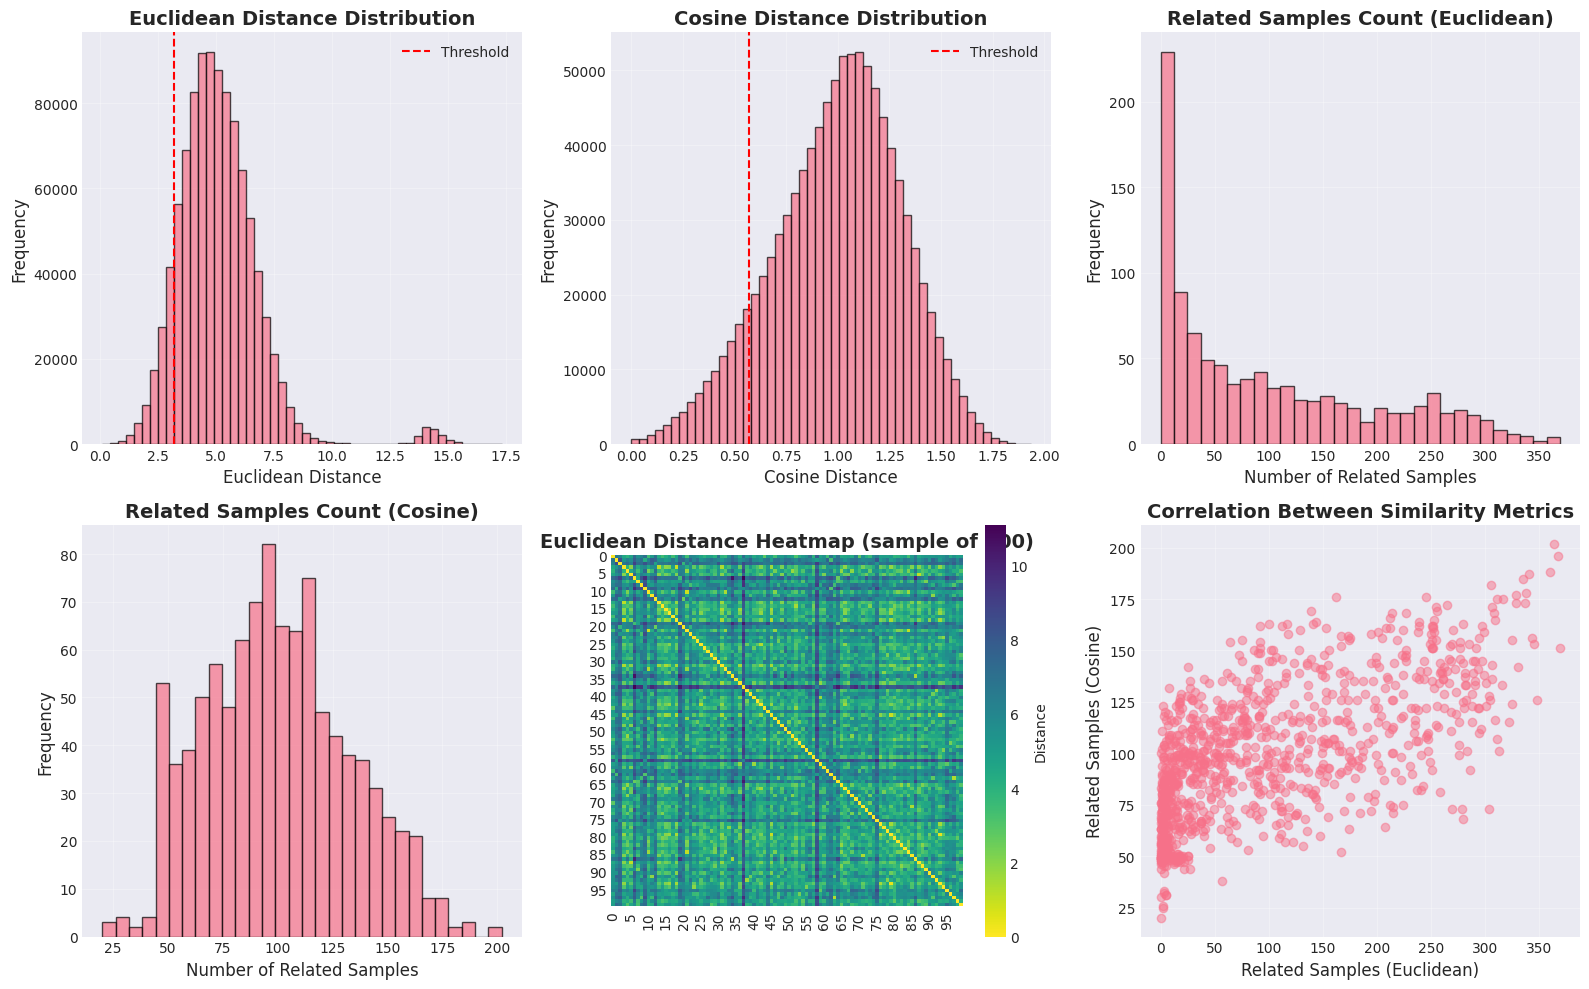


=== Summary Statistics ===
Euclidean Distance - Mean: 5.0943, Std: 1.7952
Cosine Distance - Mean: 0.9960, Std: 0.3098

Related Samples (Euclidean) - Mean: 99.90, Std: 96.62
Related Samples (Cosine) - Mean: 99.93, Std: 32.80


In [7]:
plt.figure(figsize=(16, 10))

# Distance distribution
plt.subplot(2, 3, 1)
euclidean_flat = euclidean_dist[euclidean_dist > 0].flatten()
plt.hist(euclidean_flat, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(threshold_euclidean, color='r', linestyle='--', label='Threshold')
plt.xlabel('Euclidean Distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Euclidean Distance Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Cosine distance distribution
plt.subplot(2, 3, 2)
cosine_flat = cosine_dist[cosine_dist > 0].flatten()
plt.hist(cosine_flat, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(threshold_cosine, color='r', linestyle='--', label='Threshold')
plt.xlabel('Cosine Distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Cosine Distance Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Related samples count (Euclidean)
plt.subplot(2, 3, 3)
plt.hist(related_counts_euclidean, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Number of Related Samples', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Related Samples Count (Euclidean)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Related samples count (Cosine)
plt.subplot(2, 3, 4)
plt.hist(related_counts_cosine, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Number of Related Samples', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Related Samples Count (Cosine)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Similarity heatmap (small subset)
plt.subplot(2, 3, 5)
heatmap_size = min(100, n_samples_analysis)
heatmap_indices = np.random.choice(n_samples_analysis, heatmap_size, replace=False)
sns.heatmap(euclidean_dist[np.ix_(heatmap_indices, heatmap_indices)], 
            cmap='viridis_r', cbar_kws={'label': 'Distance'}, square=True)
plt.title(f'Euclidean Distance Heatmap (sample of {heatmap_size})', fontsize=14, fontweight='bold')

# Correlation between metrics
plt.subplot(2, 3, 6)
plt.scatter(related_counts_euclidean, related_counts_cosine, alpha=0.5)
plt.xlabel('Related Samples (Euclidean)', fontsize=12)
plt.ylabel('Related Samples (Cosine)', fontsize=12)
plt.title('Correlation Between Similarity Metrics', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== Summary Statistics ===")
print(f"Euclidean Distance - Mean: {euclidean_flat.mean():.4f}, Std: {euclidean_flat.std():.4f}")
print(f"Cosine Distance - Mean: {cosine_flat.mean():.4f}, Std: {cosine_flat.std():.4f}")
print(f"\nRelated Samples (Euclidean) - Mean: {related_counts_euclidean.mean():.2f}, Std: {related_counts_euclidean.std():.2f}")
print(f"Related Samples (Cosine) - Mean: {related_counts_cosine.mean():.2f}, Std: {related_counts_cosine.std():.2f}")

## Analysis and Conclusions

### Key Observations:

1. **Sample Density**: Some samples have many close neighbors, others are isolated
2. **Metric Agreement**: Euclidean and cosine similarity may identify different relationships
3. **Dataset Structure**: The distribution of related samples reveals clustering patterns

### Research Insights:

- Understanding sample relationships helps identify potential generalization challenges
- Dense regions may indicate redundant information
- Isolated samples may be outliers or unique cases
- Different similarity metrics capture different aspects of relationships